# Using Physics-Based Loss to Better Generalize Model Training 
From modified Beer-Lambert Law, we know that 
$$
\Delta OD = <L_i(r)> \Delta \mu_(a,i)
$$
Where, $\Delta OD$ is the pulsation ratio(for a given wavelength) defined as $log(I_2)/log(I_1)$, i is the index of the tissue layer where pulsation occurs, $<L>$ corresponds to the source-detector distance (SDD) dependent **mean** photon pathlength within that layer. This can be further modified as 
$$
\Delta OD = <L_i(r)> \Delta c_(Hb) \times \epsilon(S)
$$
The corresponding loss term should thus be
$$
(\Delta OD - <L_i(r)> \Delta c_(Hb) \times \epsilon(S)) ^ 2
$$


In [1]:
from pathlib import Path
import json
from torch.optim import Adam, SGD
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from model_trainer import (
    ModelTrainer,
    RandomSplit,
    CVSplit,
    SumLoss,
    TorchLossWrapper,
    DataLoaderGenerator3,
)
from inverse_modelling_tfo.model_training.loss_funcs import BLPathlengthLoss, TorchLossWithChangingWeight

from inverse_modelling_tfo.model_training.custom_models import (
    PerceptronBD,
    CNN2FC,
    FeatureResidualNetwork,
    CNN2FC2dInput,
    SplitChannelCNN,
)
from inverse_modelling_tfo.visualization import generate_model_error_and_prediction
import torchinfo
from inverse_modelling_tfo.misc.misc_training import set_seed

# Set my GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
%load_ext autoreload
%autoreload 2

# Load Pre-save data

In [3]:
# Load in pre-saved data
from pathlib import Path
import json
import pandas as pd
import numpy as np

# Load the log intensity data
i1_and_i2_data_path = Path().resolve().parent.parent / "data" / "processed_data" / "I1_and_I2.pkl"
i1_and_i2 = pd.read_pickle(i1_and_i2_data_path)
i1_and_i2_config_path = i1_and_i2_data_path.with_suffix('.json')
with open(i1_and_i2_config_path, 'r') as file:
    i1_and_i2_config = json.load(file)
intensity_columns = i1_and_i2_config['features']

# Split by wavelength and pulsation point
wv1_i1 = [x for x in intensity_columns if x.endswith('1.0_1')]
wv1_i2 = [x for x in intensity_columns if x.endswith('1.0_2')]
wv2_i1 = [x for x in intensity_columns if x.endswith('2.0_1')]
wv2_i2 = [x for x in intensity_columns if x.endswith('2.0_2')]

# Load the exp terms data
l4_dist_data_path = Path().resolve().parent.parent / "data" / "processed_data" / "l4_bins.pkl"
l4_dist_term = pd.read_pickle(l4_dist_data_path)
l4_dist_config_path = l4_dist_data_path.with_suffix('.json')
with open(l4_dist_config_path, 'r') as file:
    l4_dist_config = json.load(file)
chosen_detector_index = l4_dist_config['chosen_detector_index']

# Sort by wavelength
l4_dist_columns = l4_dist_config['features']
l4_dist_columns = [str(x) for x in l4_dist_columns]
wv1_l4_dist = (l4_dist_term[l4_dist_term['Wave Int'] == 1])[['Maternal Wall Thickness'] + l4_dist_columns]
wv2_l4_dist = (l4_dist_term[l4_dist_term['Wave Int'] == 2])[['Maternal Wall Thickness'] + l4_dist_columns]
# Set indices to Maternal Wall Thickness for easy mapping
wv1_l4_dist.set_index('Maternal Wall Thickness', inplace=True)
wv2_l4_dist.set_index('Maternal Wall Thickness', inplace=True)

# Start putting everytghing onto data
data = i1_and_i2.copy()
for column in l4_dist_columns:
    data[column + ' WV1'] = data['Maternal Wall Thickness'].map(wv1_l4_dist[column])
    data[column + ' WV2'] = data['Maternal Wall Thickness'].map(wv2_l4_dist[column])
    
print("Length of Data: ", len(data))
print("Data Columns", data.columns)

# Calculate mu's
from inverse_modelling_tfo.tools.optical_properties import get_tissue_mu_a

def calculate_mua0_wv2(row):
    mu_a = get_tissue_mu_a(0.1, row["Fetal Hb Concentration 1"], row["Fetal Saturation"], wave_int=2)
    return mu_a

def calculate_mua1_wv2(row):
    mu_a = get_tissue_mu_a(0.1, row["Fetal Hb Concentration 2"], row["Fetal Saturation"], wave_int=2)
    return mu_a

def calculate_mua0_wv1(row):
    mu_a = get_tissue_mu_a(0.1, row["Fetal Hb Concentration 1"], row["Fetal Saturation"], wave_int=1)
    return mu_a

def calculate_mua1_wv1(row):
    mu_a = get_tissue_mu_a(0.1, row["Fetal Hb Concentration 2"], row["Fetal Saturation"], wave_int=1)
    return mu_a

data["Fetal Mua 1 WV2"] = data.apply(calculate_mua0_wv2, axis=1)
data["Fetal Mua 2 WV2"] = data.apply(calculate_mua1_wv2, axis=1)
data["Fetal Mua 1 WV1"] = data.apply(calculate_mua0_wv1, axis=1)
data["Fetal Mua 2 WV1"] = data.apply(calculate_mua1_wv1, axis=1)

# Calculate Pulsation Ratio at the chosen detector index
data["PR WV1"] = (data[wv1_i2[chosen_detector_index]] - data[wv1_i1[chosen_detector_index]]) / data[wv1_i2[chosen_detector_index]]
data["PR WV2"] = (data[wv2_i2[chosen_detector_index]] - data[wv2_i1[chosen_detector_index]]) / data[wv2_i2[chosen_detector_index]]

Length of Data:  33480
Data Columns Index(['10_2.0_1', '15_2.0_1', '19_2.0_1', '24_2.0_1', '28_2.0_1', '33_2.0_1',
       '37_2.0_1', '41_2.0_1', '46_2.0_1', '50_2.0_1',
       ...
       '19.56159 WV1', '19.56159 WV2', '37.44415 WV1', '37.44415 WV2',
       '71.67437 WV1', '71.67437 WV2', '137.19674 WV1', '137.19674 WV2',
       '262.61751 WV1', '262.61751 WV2'],
      dtype='object', length=107)


In [4]:
# Filter data so I don't have to wait for too long during training
# data = data[
#     (data["Maternal Wall Thickness"] >= 4.0)
#     & (data["Maternal Wall Thickness"] <= 20.0)
# ]
print("training with", len(data), "samples")

training with 33480 samples


In [5]:
# Clean up
mu_columns = ["Fetal Mua 1 WV1", "Fetal Mua 2 WV1", "Fetal Mua 1 WV2", "Fetal Mua 2 WV2"]
l4_dist_columns = [x + ' WV1' for x in l4_dist_columns] + [x + ' WV2' for x in l4_dist_columns]
pr_columns = ["PR WV1", "PR WV2"]
columns_to_keep = intensity_columns + mu_columns + l4_dist_columns + pr_columns + ["Maternal Wall Thickness"]
extra_data_columns = [column for column in data.columns if column not in columns_to_keep]
data = data.drop(columns=extra_data_columns)

# Setup Training Objective

In [6]:
# Predict the mu_a as well as the pathlengths for each detector
y_columns = mu_columns + l4_dist_columns
x_columns = intensity_columns


## Normalizing Features
x_columns will be the input features and y_columns are the target

In [7]:
## Pass in maternal info
# x_columns += ["Maternal Hb Concentration", "Maternal Saturation"]
# x_columns = list(filter(lambda X: 'alpha' in X, data.columns))
## Scale y
y_scaler = preprocessing.StandardScaler()
data[y_columns] = y_scaler.fit_transform(data[y_columns])

## Scale x
## Scheme 1 - Per detector normalization
x_scaler = preprocessing.StandardScaler()
data[x_columns] = x_scaler.fit_transform(data[x_columns])

## Model Configuration

In [8]:
print("In Features :", x_columns)  
print("In Features Len:", len(x_columns))
print("Out Features:", y_columns)
print("Out Features Len:", len(y_columns))
print("Extra Features:", pr_columns)
print("Extra Features Len:", len(pr_columns))

In Features : ['10_2.0_1', '15_2.0_1', '19_2.0_1', '24_2.0_1', '28_2.0_1', '33_2.0_1', '37_2.0_1', '41_2.0_1', '46_2.0_1', '50_2.0_1', '55_2.0_1', '59_2.0_1', '64_2.0_1', '68_2.0_1', '72_2.0_1', '77_2.0_1', '81_2.0_1', '86_2.0_1', '90_2.0_1', '94_2.0_1', '10_1.0_1', '15_1.0_1', '19_1.0_1', '24_1.0_1', '28_1.0_1', '33_1.0_1', '37_1.0_1', '41_1.0_1', '46_1.0_1', '50_1.0_1', '55_1.0_1', '59_1.0_1', '64_1.0_1', '68_1.0_1', '72_1.0_1', '77_1.0_1', '81_1.0_1', '86_1.0_1', '90_1.0_1', '94_1.0_1', '10_2.0_2', '15_2.0_2', '19_2.0_2', '24_2.0_2', '28_2.0_2', '33_2.0_2', '37_2.0_2', '41_2.0_2', '46_2.0_2', '50_2.0_2', '55_2.0_2', '59_2.0_2', '64_2.0_2', '68_2.0_2', '72_2.0_2', '77_2.0_2', '81_2.0_2', '86_2.0_2', '90_2.0_2', '94_2.0_2', '10_1.0_2', '15_1.0_2', '19_1.0_2', '24_1.0_2', '28_1.0_2', '33_1.0_2', '37_1.0_2', '41_1.0_2', '46_1.0_2', '50_1.0_2', '55_1.0_2', '59_1.0_2', '64_1.0_2', '68_1.0_2', '72_1.0_2', '77_1.0_2', '81_1.0_2', '86_1.0_2', '90_1.0_2', '94_1.0_2']
In Features Len: 80
Out F

# Defining A Custom Physics Based Loss

In [9]:
from typing import List
from model_trainer import LossFunction
from sklearn.preprocessing import StandardScaler

# TODO: Move these to loss_func eventially 
class ExpBasedPhysicsLoss(LossFunction):
    def __init__(
        self,
        mu1_wv1_index: int,
        mu1_wv2_index: int,
        mu2_wv1_index: int,
        mu2_wv2_index: int,
        wv1_dist_indices: List[int],
        wv2_dist_indices: List[int],
        center_values: List[float],
        model_output_scaler: StandardScaler,
        device: torch.device = torch.device("cuda"),
        name: str = "ExpBasedPhysicsLoss",
    ):
        """
        Calculate the residue in true pulsation ratio vs. pulsation ratio predicted using the model's l4 distribution 
        and mu_a prediction. This is based on my personal formula which in theory should be more accurate than the
        previous one.
        
        :param mu1_wv1_index: The index of the mu_a at I1 for the first wavelength in the model's output
        :param mu1_wv2_index: The index of the mu_a at I2 for the second wavelength in the model's output
        :param mu2_wv1_index: The index of the mu_a at I1 for the first wavelength in the model's output
        :param mu2_wv2_index: The index of the mu_a at I2 for the second wavelength in the model's output
        :param wv1_dist_indices: The indices of the l4 distribution at the first wavelength in the model's output
        :param wv2_dist_indices: The indices of the l4 distribution at the second wavelength in the model's output
        :param center_values: The center values of the l4 distribution as a list of floats
        :param model_output_scaler: The scaler used to scale the model's output
        :param device: The device to run the loss function on
        :param name: The name of the loss function. Default is "ExpBasedPhysicsLoss"
        
        Note: This loss expects that the first and second element in dataloader's extra data (2nd index) contains the 
        true unscaled pulsation ratio. 
        
        """
        super().__init__(name=name)
        self.mu1_wv1_index = mu1_wv1_index
        self.mu1_wv2_index = mu1_wv2_index
        self.mu2_wv1_index = mu2_wv1_index
        self.mu2_wv2_index = mu2_wv2_index
        self.wv1_dist_indices = torch.tensor(wv1_dist_indices, device=device)
        self.wv2_dist_indices = torch.tensor(wv2_dist_indices, device=device)
        scaler_mean = model_output_scaler.mean_
        scaler_scale = model_output_scaler.scale_
        scaler_mean = torch.tensor(scaler_mean, device=device)
        scaler_scale = torch.tensor(scaler_scale, device=device)
        self.mu1_wv1_mean = scaler_mean[mu1_wv1_index]
        self.mu1_wv1_scale = scaler_scale[mu1_wv1_index]
        self.mu1_wv2_mean = scaler_mean[mu1_wv2_index]
        self.mu1_wv2_scale = scaler_scale[mu1_wv2_index]
        self.mu2_wv1_mean = scaler_mean[mu2_wv1_index]
        self.mu2_wv1_scale = scaler_scale[mu2_wv1_index]
        self.mu2_wv2_mean = scaler_mean[mu2_wv2_index]
        self.mu2_wv2_scale = scaler_scale[mu2_wv2_index]
        self.wv1_dist_indices_scale = scaler_scale[wv1_dist_indices].unsqueeze(0)
        self.wv1_dist_indices_mean = scaler_mean[wv1_dist_indices].unsqueeze(0)
        self.wv2_dist_indices_scale = scaler_scale[wv2_dist_indices].unsqueeze(0)
        self.wv2_dist_indices_mean = scaler_mean[wv2_dist_indices].unsqueeze(0)
        self.center_values = torch.tensor(center_values, device=device).unsqueeze(0)
    
    def __call__(self, model_output, dataloader_data, trainer_mode: str):
        # Unscale the model output
        mu1_wv1 = model_output[:, self.mu1_wv1_index].unsqueeze(1) * self.mu1_wv1_scale + self.mu1_wv1_mean
        mu1_wv2 = model_output[:, self.mu1_wv2_index].unsqueeze(1) * self.mu1_wv2_scale + self.mu1_wv2_mean
        mu2_wv1 = model_output[:, self.mu2_wv1_index].unsqueeze(1) * self.mu2_wv1_scale + self.mu2_wv1_mean
        mu2_wv2 = model_output[:, self.mu2_wv2_index].unsqueeze(1) * self.mu2_wv2_scale + self.mu2_wv2_mean
        wv1_dist = model_output[:, self.wv1_dist_indices] * self.wv1_dist_indices_scale + self.wv1_dist_indices_mean
        wv2_dist = model_output[:, self.wv2_dist_indices] * self.wv2_dist_indices_scale + self.wv2_dist_indices_mean
        
        # Convert wv1_dist and wv2_dist exp(-mu_a * center_values)
        wv1_i1 = wv1_dist * torch.exp(- mu1_wv1 * self.center_values)
        wv1_i2 = wv1_dist * torch.exp(- mu2_wv1 * self.center_values)
        wv2_i1 = wv2_dist * torch.exp(- mu1_wv2 * self.center_values)
        wv2_i2 = wv2_dist * torch.exp(- mu2_wv2 * self.center_values)
        
        # Accumulate (All of these are 1D)
        wv1_i1 = wv1_i1.sum(dim=1)
        wv1_i2 = wv1_i2.sum(dim=1)
        wv2_i1 = wv2_i1.sum(dim=1)
        wv2_i2 = wv2_i2.sum(dim=1)
        
        # Calculate approximate pulsation ratio from mu and l4_dist prediction
        pr_wv1 = (wv1_i2 - wv1_i1) / wv1_i2 # 1D
        pr_wv2 = (wv2_i2 - wv2_i1) / wv2_i2 # 1D
        
        # Calculate the error
        pr_wv1_target = dataloader_data[2][:, 0] # 1D
        pr_wv2_target = dataloader_data[2][:, 1] # 1D
        
        # Calculate the loss
        loss = torch.square(pr_wv1 - pr_wv1_target).mean() + torch.square(pr_wv2 - pr_wv2_target).mean()
        
        # Update Tracker
        self.loss_tracker_step_update(loss.item(), trainer_mode)
        return loss

    def __str__(self):
        return f"Compare the pulsation ratio prediction using l4 dist and mu_a with the target pulsation ratio"

# Training Configs

In [10]:
from model_trainer import HoldOneOut, RandomSplit

# Params
IN_FEATURES = len(x_columns)
OUT_FEATURES = len(y_columns)
set_seed(42)
data_loader_params = {"shuffle": True}  # Shuffles the data in between epochs - thought to be a good idea
dataloader_gen = DataLoaderGenerator3(data, x_columns, y_columns, pr_columns, 512, data_loader_params)

# Calculate the centers
centers = [x for x in l4_dist_columns[: len(l4_dist_columns) // 2]]
centers = [float(x.split(" ")[0]) for x in centers]

# Define the losses
criterion0 = TorchLossWrapper(nn.MSELoss(), [0, 1, 2, 3], name="label_mua")
criterion1 = TorchLossWrapper(nn.MSELoss(), list(range(4, 4 + len(l4_dist_columns))), name="label_l4_dist")
criterion3 = ExpBasedPhysicsLoss(
    0,
    2,
    1,
    3,
    list(range(4, 4 + len(l4_dist_columns) // 2)),
    list(range(4 + len(l4_dist_columns) // 2, 4 + len(l4_dist_columns))),
    centers,
    y_scaler,
    torch.device("cuda"),
)
criterion = SumLoss([criterion0, criterion1, criterion3], [1.0, 1.0, 1e4])

model = PerceptronBD([IN_FEATURES, 40, 30, 25, OUT_FEATURES])

# validation_method = RandomSplit(0.8)
all_depth = data["Maternal Wall Thickness"].unique()
all_depth.sort()
validation_method = HoldOneOut("Maternal Wall Thickness", all_depth[3])

trainer = ModelTrainer(model, dataloader_gen, validation_method, criterion)

## Custom Training

In [11]:
# trainer.set_batch_size(32)
trainer.set_batch_size(64)
trainer.set_optimizer(SGD, {'lr': 5e-3, 'momentum': 0.89, 'weight_decay': 1e-4})
trainer.run(100)

KeyboardInterrupt: 

Unweighted Training Label loss(MSE) 0.6516588626084504
Unweighted Validation Label loss(MSE) 0.48265252919758067


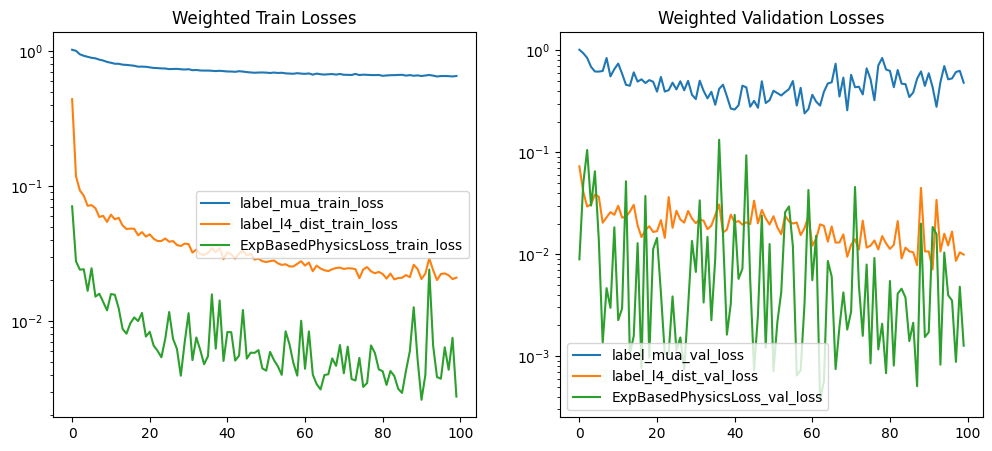

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.flatten()
for index, loss_sets in enumerate([criterion.train_losses, criterion.val_losses]):
    plt.sca(axes[index])
    for loss in loss_sets:
        plt.plot(criterion.loss_tracker.epoch_losses[loss], label=loss)
    plt.legend()
    plt.yscale('log')
    plt.title("Weighted Train Losses" if index == 0 else "Weighted Validation Losses")

print("Unweighted Training Label loss(MSE)", criterion0.loss_tracker.epoch_losses['label_mua_train_loss'][-1])
print("Unweighted Validation Label loss(MSE)", criterion0.loss_tracker.epoch_losses['label_mua_val_loss'][-1])
fig_loss = plt.gcf()

In [ ]:
# Increase batch_size for faster visuals generation - (does not affect training!)
prev_batch_size = dataloader_gen.batch_size
trainer.set_batch_size(4096)
# Does MAE by default. Provide a value to error_func to change it
train_error, train_pred = generate_model_error_and_prediction(trainer.model, trainer.train_loader, y_columns, y_scaler)
val_error, val_pred = generate_model_error_and_prediction(trainer.model, trainer.validation_loader, y_columns, y_scaler)
trainer.set_batch_size(prev_batch_size)

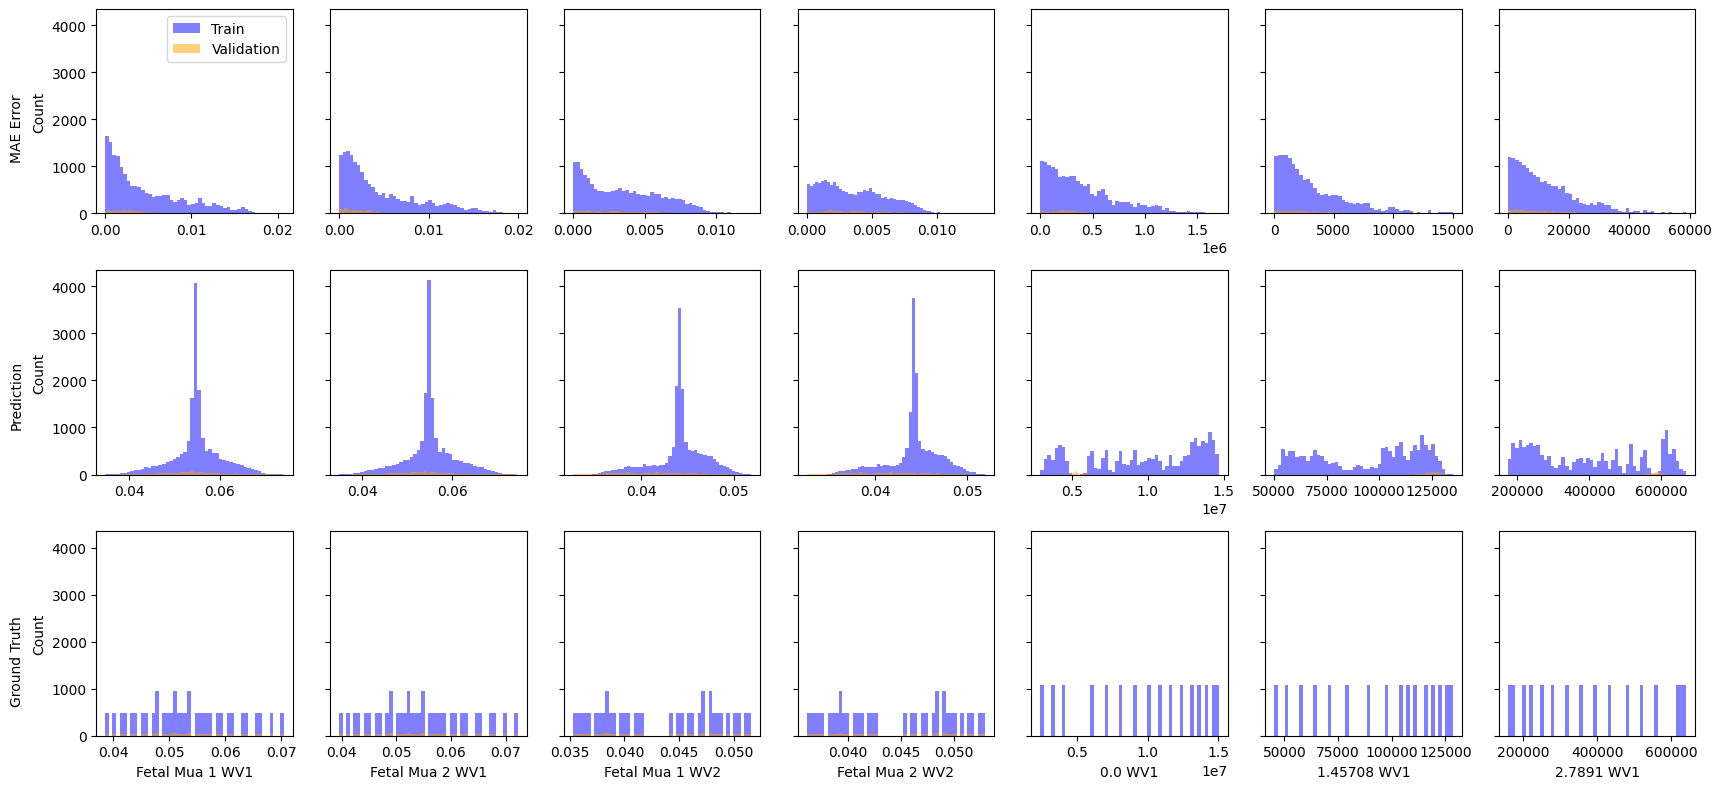

In [ ]:
PLOT_FIRST_N = 7
y_columns_to_plot = y_columns[:PLOT_FIRST_N]
fig_dist, axes = plt.subplots(3, len(y_columns_to_plot), squeeze=True, figsize=(17, 8), sharey=True)
BIN_COUNT = 50

train_data_truth = y_scaler.inverse_transform(trainer.train_loader.dataset[:][1].cpu())
val_data_truth = y_scaler.inverse_transform(trainer.validation_loader.dataset[:][1].cpu())

for i in range(len(y_columns_to_plot)):
    # Plot Errors
    ax = axes[0, i]
    plt.sca(ax)
    column_name = train_error.columns[i]
    plt.hist(train_error[column_name], bins=BIN_COUNT, color='blue', alpha=0.5, label='Train')
    plt.hist(val_error[column_name], bins=BIN_COUNT, color='orange', alpha=0.5, label='Validation')

    
    # Plot Predictions
    ax = axes[1, i]
    plt.sca(ax)
    column_name = train_pred.columns[i]
    plt.hist(train_pred[column_name], bins=BIN_COUNT, color='blue', alpha=0.5, label='Train')
    plt.hist(val_pred[column_name], bins=BIN_COUNT, color='orange', alpha=0.5, label='Validation')

    
    # Plot Ground Truth
    ax = axes[2, i]
    plt.sca(ax)
    plt.hist(train_data_truth[:, i], bins=BIN_COUNT, color='blue', alpha=0.5, label='Train')
    plt.hist(val_data_truth[:, i], bins=BIN_COUNT, color='orange', alpha=0.5, label='Validation')

    # X Label for the bottommost row
    plt.xlabel(y_columns[i])
    
# Add text to the left of each row of plots
for i, label in enumerate(['MAE Error', 'Prediction', 'Ground Truth']):
    fig_dist.text(0, (2.5-i)/3, label, ha='center', va='center', rotation='vertical')

# Y Labels
for i in range(axes.shape[0]):
    axes[i, 0].set_ylabel('Count')

# Add labels to top-left subplot
axes[0, 0].legend()


plt.tight_layout()
plt.show()

In [ ]:
print("Unnormalized Errors", str(train_error.iloc[:, :4].describe()) + '\n\n' + str(val_error.iloc[:, :4].describe())) 

Unnormalized Errors        Fetal Mua 1 WV1 Error  Fetal Mua 2 WV1 Error  Fetal Mua 1 WV2 Error  \
count           1.728000e+04           1.728000e+04           1.728000e+04   
mean            4.748433e-03           4.699953e-03           3.526070e-03   
std             4.341389e-03           4.309143e-03           2.638672e-03   
min             6.572225e-08           3.221679e-07           3.653637e-07   
25%             1.214609e-03           1.332959e-03           1.099751e-03   
50%             3.269813e-03           3.080898e-03           3.171469e-03   
75%             7.345783e-03           7.176302e-03           5.562048e-03   
max             2.072682e-02           1.990883e-02           1.223536e-02   

       Fetal Mua 2 WV2 Error  
count           17280.000000  
mean                0.003648  
std                 0.002461  
min                 0.000001  
25%                 0.001524  
50%                 0.003289  
75%                 0.005462  
max                 0.011410 

In [ ]:
# Model Info
torchinfo.summary(trainer.model)

Layer (type:depth-idx)                   Param #
PerceptronBD                             --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       3,240
│    └─BatchNorm1d: 2-2                  80
│    └─ReLU: 2-3                         --
│    └─Linear: 2-4                       1,230
│    └─BatchNorm1d: 2-5                  60
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       775
│    └─BatchNorm1d: 2-8                  50
│    └─ReLU: 2-9                         --
│    └─Linear: 2-10                      624
│    └─Flatten: 2-11                     --
Total params: 6,059
Trainable params: 6,059
Non-trainable params: 0

In [ ]:
# model_name = 'no_physics_loss_pr_to_mua'
# import joblib
# # Save Model
# torch.save(model.state_dict(), rf'../../models/{model_name}.pth')
# # Save the Scalers for Later Use
# joblib.dump(x_scaler, rf'../../models/{model_name}_xscaler')
# joblib.dump(y_scaler, rf'../../models/{model_name}_yscaler') 

In [ ]:
# # Load Model Code
# model = PerceptronReLU([20, 10, 4, 2, 1])
# model.load_state_dict(torch.load(r'../models/fsat_delta_5det_v1'))
# model = model.cuda()
# x_scaler = joblib.load(rf'../models/{model_name}_xscaler')
# y_scaler = joblib.load(rf'../models/{model_name}_yscaler')

In [ ]:
# from mdreport import MarkdownReport
# # Generate report

# report = MarkdownReport(Path('results'), 'report19', 'Returning Back to Hold-One Out Validation')
# report.add_text_report("Comment", "Same as report 18, but this time we drop the wavelength BL loss and only keep this delta C loss.")
# report.add_text_report("Comment", "This generalizes slightly better but still the generalization sucks. The training loss is pretty low though. ")
# report.add_code_report("Model Used", str(torchinfo.summary(trainer.model)))
# report.add_code_report("Unnormalized Errors", str(train_error.iloc[:, :4].describe()) + '\n\n' + str(val_error.iloc[:, :4].describe())) 
# report.add_text_report("Loss", f"""Mua Label Loss(training): {criterion0.loss_tracker.epoch_losses['label_mua_train_loss'][-1]},
#                        Mua Label loss(validation): {criterion0.loss_tracker.epoch_losses['label_mua_val_loss'][-1]}""")
# report.add_code_report("Model Trainer Params", str(trainer))
# report.add_image_report("Loss Curves", fig_loss)
# report.add_image_report("Prediction & Error Distribution", fig_dist)
# report.save_report()